In [1]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Step 1: Load Data from YFinance
start_date = "2015-01-01"
end_date = "2024-10-31"
tickers = ["TSLA", "BND", "SPY"]
# Fetch adjusted closing prices for the given tickers
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  3 of 3 completed


In [3]:
# Step 2: Data Cleaning
# Check for missing values and fill them
data = data.fillna(method='ffill')

<ipython-input-3-5f860b57e15f>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


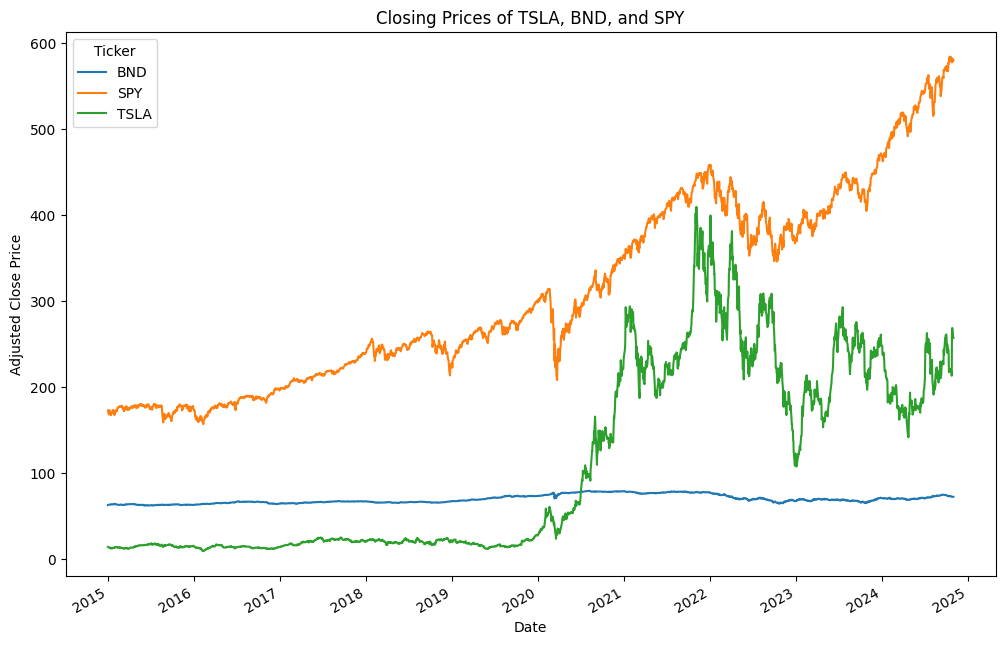

In [4]:
# Step 3: Exploratory Data Analysis
# Plot the closing prices
data.plot(title='Closing Prices of TSLA, BND, and SPY', figsize=(12, 8))
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.show()

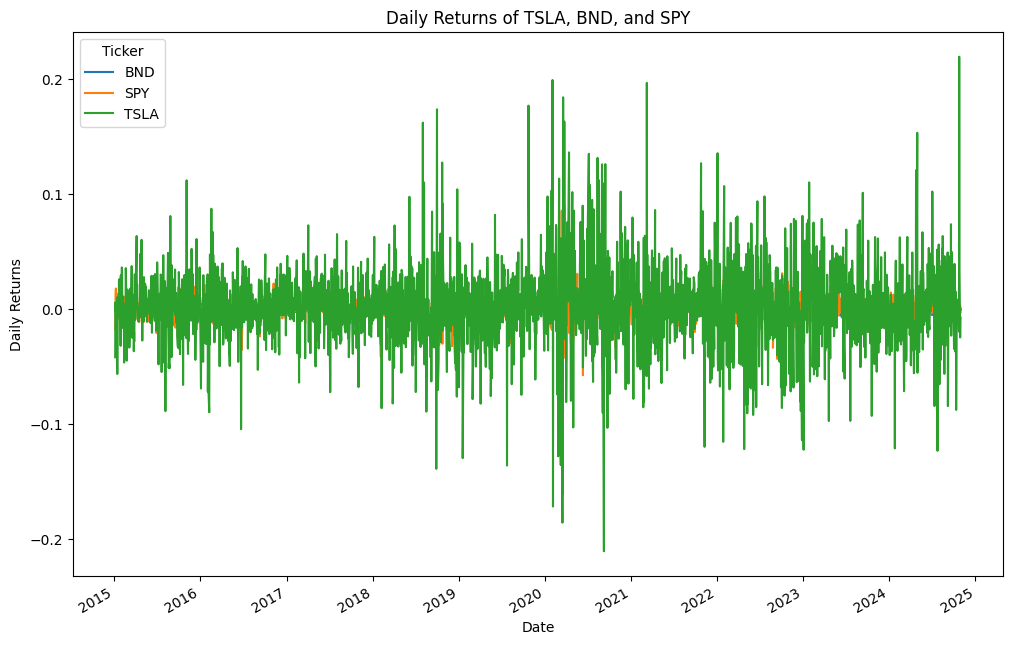

In [5]:
# Daily percentage change to analyze returns and volatility
daily_returns = data.pct_change().dropna()
daily_returns.plot(title='Daily Returns of TSLA, BND, and SPY', figsize=(12, 8))
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.show()

In [6]:
# Step 4: ARIMA Forecasting Model for Tesla Stock (TSLA)
# Extract Tesla's adjusted closing price series
tsla_data = data['TSLA']
train_data = tsla_data[:int(0.8 * len(tsla_data))]  # 80% training data
test_data = tsla_data[int(0.8 * len(tsla_data)):]  # 20% test data

In [7]:
# Build and fit ARIMA model
model = ARIMA(train_data, order=(5, 1, 0))  # Adjust (p, d, q) as needed
arima_model = model.fit()
# Forecast the test set
forecast = arima_model.forecast(steps=len(test_data))
forecast_index = test_data.index

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

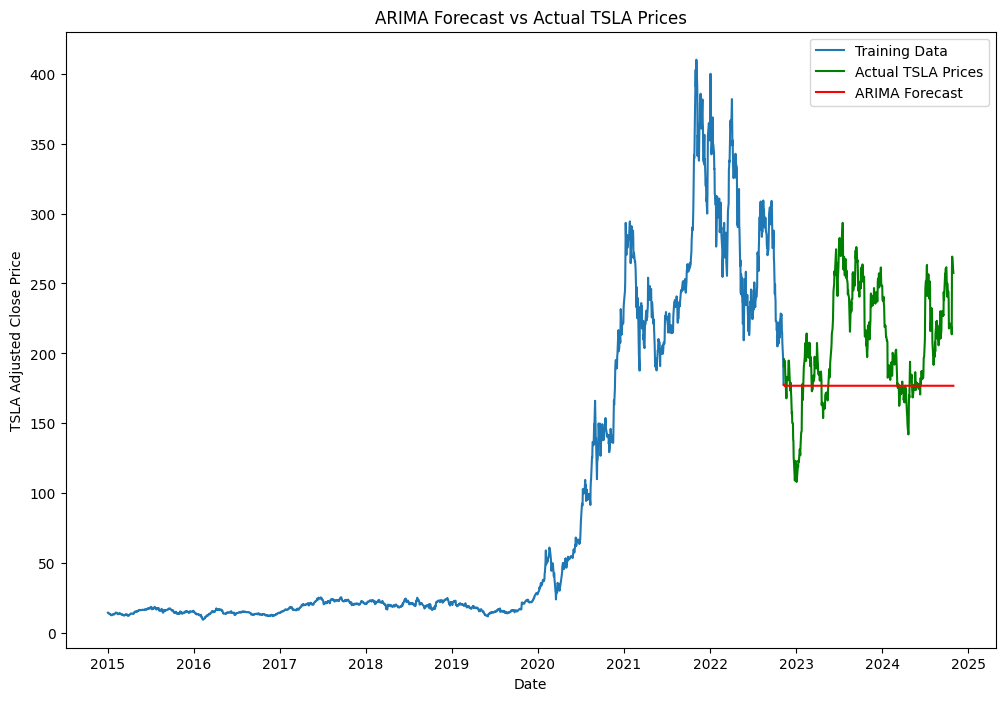

In [8]:
# Plot forecast vs actual
plt.figure(figsize=(12, 8))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual TSLA Prices', color='green')
plt.plot(forecast_index, forecast, label='ARIMA Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('TSLA Adjusted Close Price')
plt.legend()
plt.title('ARIMA Forecast vs Actual TSLA Prices')
plt.show()

In [9]:
# Calculate model evaluation metrics
mae = mean_absolute_error(test_data, forecast)
rmse = mean_squared_error(test_data, forecast, squared=False)
print(f"MAE: {mae}, RMSE: {rmse}")

# Step 5: Extend Forecast for 6-12 Months
forecast_future = arima_model.get_forecast(steps=180)  # 6-month forecast
forecast_ci = forecast_future.conf_int()

MAE: 39.313251901468895, RMSE: 49.56620021820765


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


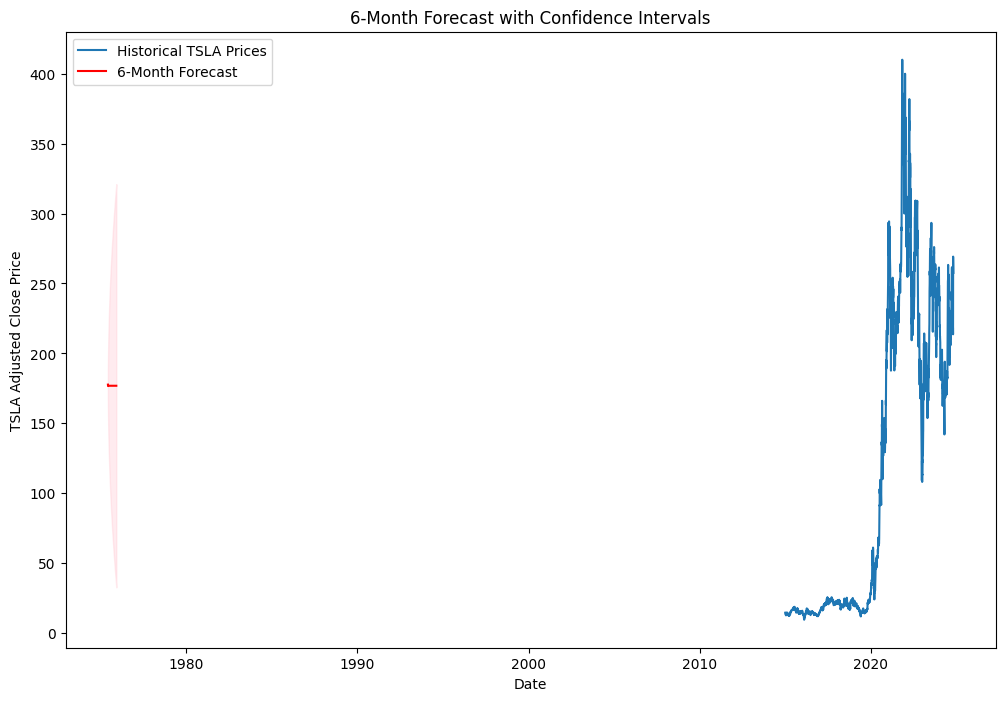

In [10]:
# Plot forecast with confidence intervals
plt.figure(figsize=(12, 8))
plt.plot(tsla_data, label='Historical TSLA Prices')
plt.plot(forecast_future.predicted_mean.index, forecast_future.predicted_mean, color='red', label='6-Month Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('TSLA Adjusted Close Price')
plt.legend()
plt.title('6-Month Forecast with Confidence Intervals')
plt.show()

In [11]:
# Step 6: Portfolio Optimization based on Forecast
# Calculate average daily returns
avg_daily_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()

# Define initial portfolio weights
initial_weights = np.array([0.4, 0.4, 0.2])

# Calculate annualized portfolio return and volatility
annual_return = np.sum(avg_daily_returns * initial_weights) * 252  # Annualized
annual_volatility = np.sqrt(np.dot(initial_weights.T, np.dot(cov_matrix * 252, initial_weights)))  # Annualized
sharpe_ratio = annual_return / annual_volatility

In [12]:
# Display portfolio performance metrics
print(f"Expected Annual Portfolio Return: {annual_return}")
print(f"Annual Portfolio Volatility: {annual_volatility}")
print(f"Sharpe Ratio: {sharpe_ratio}")

# Optimization Function to Maximize Sharpe Ratio
from scipy.optimize import minimize

def neg_sharpe_ratio(weights, avg_daily_returns, cov_matrix):
    portfolio_return = np.sum(avg_daily_returns * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    return -portfolio_return / portfolio_volatility  # Negative Sharpe ratio to minimize


Expected Annual Portfolio Return: 0.1524999709045721
Annual Portfolio Volatility: 0.16270551646846865
Sharpe Ratio: 0.9372759708127393


In [13]:
# Constraints: Sum of weights = 1, bounds for each weight between 0 and 1
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
bounds = [(0, 1) for _ in range(len(initial_weights))]

# Run optimization
optimized = minimize(neg_sharpe_ratio, initial_weights, args=(avg_daily_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = optimized.x

In [14]:
# Recalculate performance metrics with optimized weights
optimal_annual_return = np.sum(avg_daily_returns * optimal_weights) * 252
optimal_annual_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix * 252, optimal_weights)))
optimal_sharpe_ratio = optimal_annual_return / optimal_annual_volatility

# Display optimized portfolio results
print("Optimized Portfolio Weights:", optimal_weights)
print(f"Optimized Annual Return: {optimal_annual_return}")
print(f"Optimized Annual Volatility: {optimal_annual_volatility}")
print(f"Optimized Sharpe Ratio: {optimal_sharpe_ratio}")


Optimized Portfolio Weights: [0.49030947 0.38151866 0.12817186]
Optimized Annual Return: 0.11878555040715434
Optimized Annual Volatility: 0.12545809532911165
Optimized Sharpe Ratio: 0.946814552664351


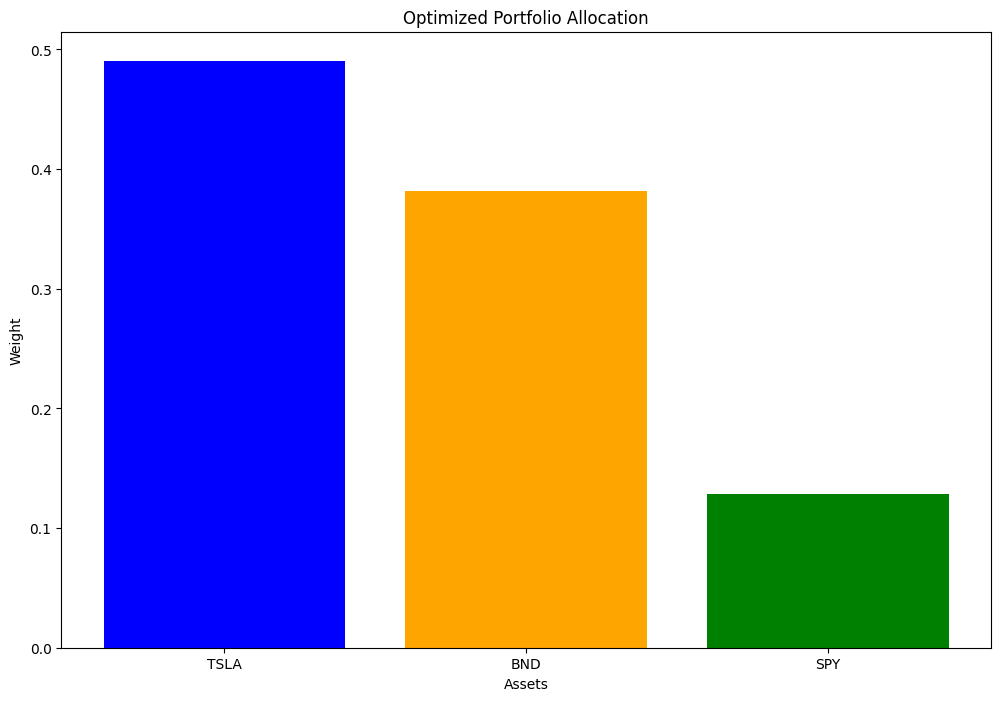

In [15]:
# Visualize Portfolio Performance with Forecasted Returns
plt.figure(figsize=(12, 8))
plt.bar(tickers, optimal_weights, color=['blue', 'orange', 'green'])
plt.title("Optimized Portfolio Allocation")
plt.xlabel("Assets")
plt.ylabel("Weight")
plt.show()